In [1]:
# ============================================================
# Importing Libraries
# ============================================================
import pandas as PD
import numpy as NP
import matplotlib.pyplot as PLT
import seaborn as SNS
from sklearn.model_selection import train_test_split as Train_Test_Split, GridSearchCV, cross_val_score as Cross_Val_Score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score as Accuracy_Score, classification_report as Classification_Report, confusion_matrix as Confusion_Matrix
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import joblib as JobLib

In [2]:
# ============================================================
# Functions for Data Loading and Preprocessing
# ============================================================
# Load data.
def Load_Data():
    return PD.read_csv("Dataset.csv")

# Pre-process data.
def PreProcess_Data(Data, Use_SMOTE=False):
    X = Data.drop('Quality', axis=1)
    Y = Data['Quality']
    X_Train, X_Test, Y_Train, Y_Test = Train_Test_Split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    if Use_SMOTE:
        SM = SMOTE(random_state=42)
        X_Train, Y_Train = SM.fit_resample(X_Train, Y_Train)
    return X_Train, X_Test, Y_Train, Y_Test

In [3]:
# ============================================================
# Functions for Model Evaluation and Visualization
# ============================================================
# Evaluate model.
def Evaluate_Model(Y_Test, Y_Pred):
    Accuracy = Accuracy_Score(Y_Test, Y_Pred)
    Report = Classification_Report(Y_Test, Y_Pred, zero_division=0)
    CM = Confusion_Matrix(Y_Test, Y_Pred)
    return Accuracy, Report, CM

# Plot confusion matrix.
def Plot_Confusion_Matrix(CM, Model_Name):
    SNS.heatmap(CM, annot=True, fmt="d", cmap='Blues')
    PLT.title(f'Confusion Matrix for {Model_Name}')
    PLT.xlabel('Predicted')
    PLT.ylabel('True')
    PLT.show()

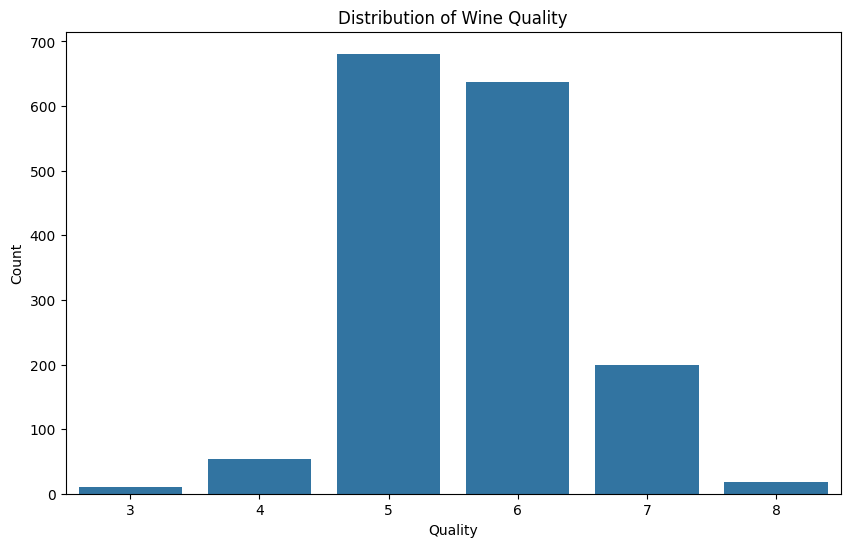

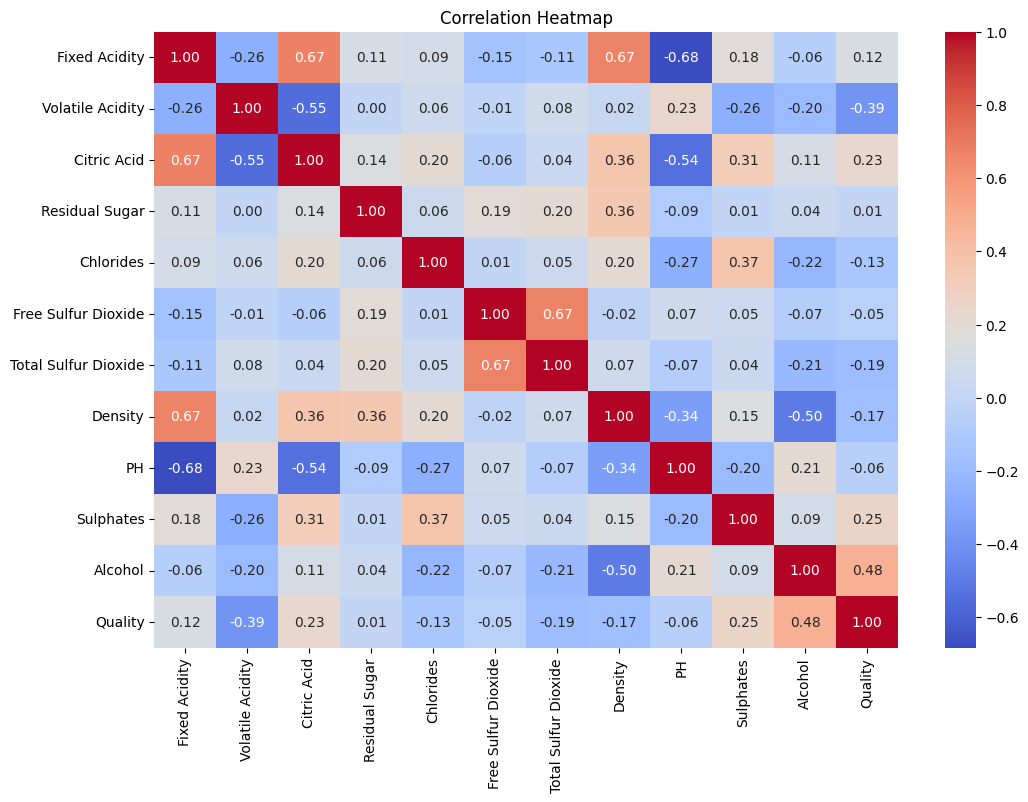

In [4]:
# ============================================================
# Data Loading and Visualization
# ============================================================
# Load the dataset.
Data = Load_Data()

# Visualize distribution of wine quality.
PLT.figure(figsize=(10, 6))
SNS.countplot(x='Quality', data=Data)
PLT.title('Distribution of Wine Quality')
PLT.xlabel('Quality')
PLT.ylabel('Count')
PLT.show()

# Correlation heatmap.
PLT.figure(figsize=(12, 8))
SNS.heatmap(Data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
PLT.title('Correlation Heatmap')
PLT.show()

# Pre-process data.
X_Train, X_Test, Y_Train, Y_Test = PreProcess_Data(Data, Use_SMOTE=True)

Logistic Regression:
Cross-Validation Score: 0.65

Test Accuracy: 0.39

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.06      0.27      0.10        11
           5       0.68      0.52      0.59       136
           6       0.51      0.27      0.35       128
           7       0.31      0.45      0.36        40
           8       0.00      0.00      0.00         3

    accuracy                           0.39       320
   macro avg       0.26      0.25      0.23       320
weighted avg       0.53      0.39      0.44       320



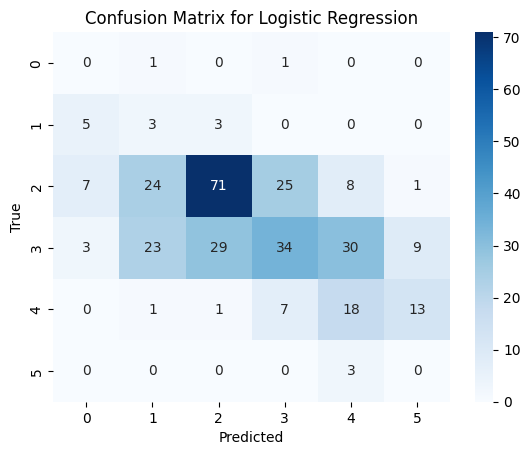

Support Vector Classifier:
Cross-Validation Score: 0.78

Test Accuracy: 0.52

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.16      0.55      0.24        11
           5       0.69      0.58      0.63       136
           6       0.60      0.44      0.50       128
           7       0.40      0.57      0.47        40
           8       0.08      0.33      0.13         3

    accuracy                           0.52       320
   macro avg       0.32      0.41      0.33       320
weighted avg       0.59      0.52      0.54       320



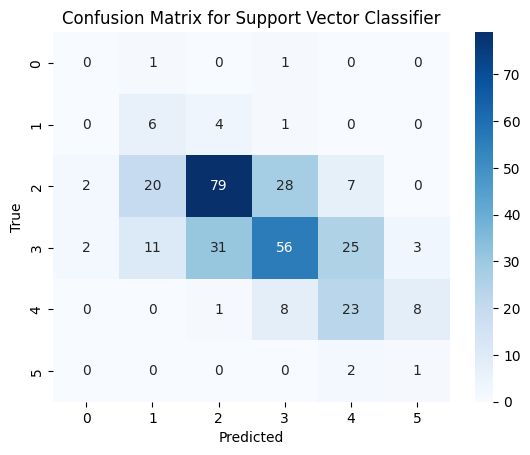

Random Forest Classifier:
Cross-Validation Score: 0.87

Test Accuracy: 0.62

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.06      0.09      0.07        11
           5       0.72      0.68      0.70       136
           6       0.65      0.60      0.62       128
           7       0.61      0.68      0.64        40
           8       0.12      0.33      0.18         3

    accuracy                           0.62       320
   macro avg       0.36      0.40      0.37       320
weighted avg       0.64      0.62      0.63       320



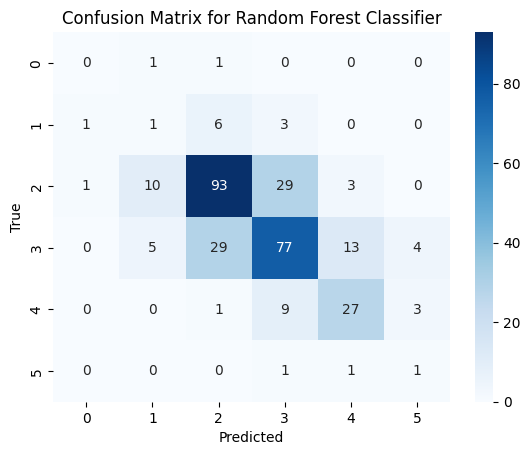

In [5]:
# ============================================================
# Model Training and Evaluation
# ============================================================
# Create pipelines for different classifiers with feature selection.
Pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k='all')),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'Support Vector Classifier': Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k='all')),
        ('classifier', SVC(random_state=42))
    ]),
    'Random Forest Classifier': Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k='all')),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
}

# Train and evaluate each model with cross-validation.
Results = {}
for Model_Name, Pipeline in Pipelines.items():
    Scores = Cross_Val_Score(Pipeline, X_Train, Y_Train, cv=5, n_jobs=-1)
    Pipeline.fit(X_Train, Y_Train)
    Y_Pred = Pipeline.predict(X_Test)
    Accuracy, Report, CM = Evaluate_Model(Y_Test, Y_Pred)
    Results[Model_Name] = {'Cross-Validation Score': Scores.mean(), 'Test Accuracy': Accuracy}
    print(f"{Model_Name}:\nCross-Validation Score: {Scores.mean():.2f}\n")
    print(f"Test Accuracy: {Accuracy:.2f}\n")
    print(Report)
    Plot_Confusion_Matrix(CM, Model_Name)

In [6]:
# ============================================================
# Hyperparameter Tuning for Selected Models
# ============================================================
# Hyper-parameter tuning for SVC and Random Forest.
Param_Grid_RF = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}
Param_Grid_SVC = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': [1, 0.1, 0.01],
    'classifier__kernel': ['rbf']
}

# Grid search for Random Forest.
Grid_Search_RF = GridSearchCV(Pipelines['Random Forest Classifier'], Param_Grid_RF, cv=5, n_jobs=-1)
Grid_Search_RF.fit(X_Train, Y_Train)
Best_RF = Grid_Search_RF.best_estimator_

# Grid search for SVC.
Grid_Search_SVC = GridSearchCV(Pipelines['Support Vector Classifier'], Param_Grid_SVC, cv=5, n_jobs=-1)
Grid_Search_SVC.fit(X_Train, Y_Train)
Best_SVC = Grid_Search_SVC.best_estimator_

Best Random Forest Model:
Accuracy: 0.62

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.06      0.09      0.07        11
           5       0.72      0.68      0.70       136
           6       0.66      0.60      0.63       128
           7       0.58      0.70      0.64        40
           8       0.12      0.33      0.18         3

    accuracy                           0.62       320
   macro avg       0.36      0.40      0.37       320
weighted avg       0.65      0.62      0.63       320



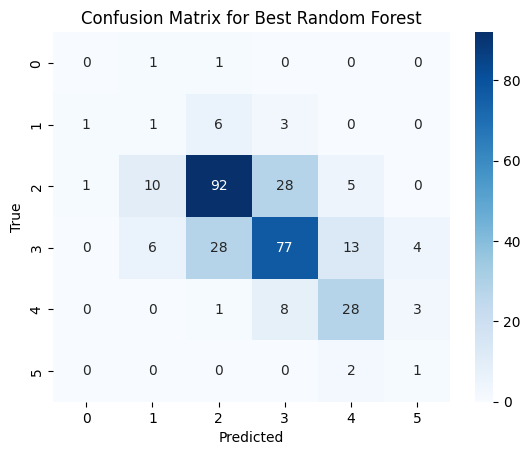

Best SVC Model:
Accuracy: 0.64

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.09      0.09      0.09        11
           5       0.69      0.70      0.70       136
           6       0.64      0.70      0.67       128
           7       0.70      0.47      0.57        40
           8       0.25      0.33      0.29         3

    accuracy                           0.64       320
   macro avg       0.40      0.38      0.38       320
weighted avg       0.64      0.64      0.64       320



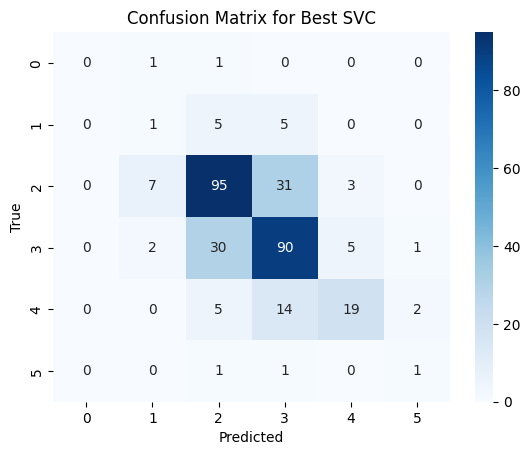

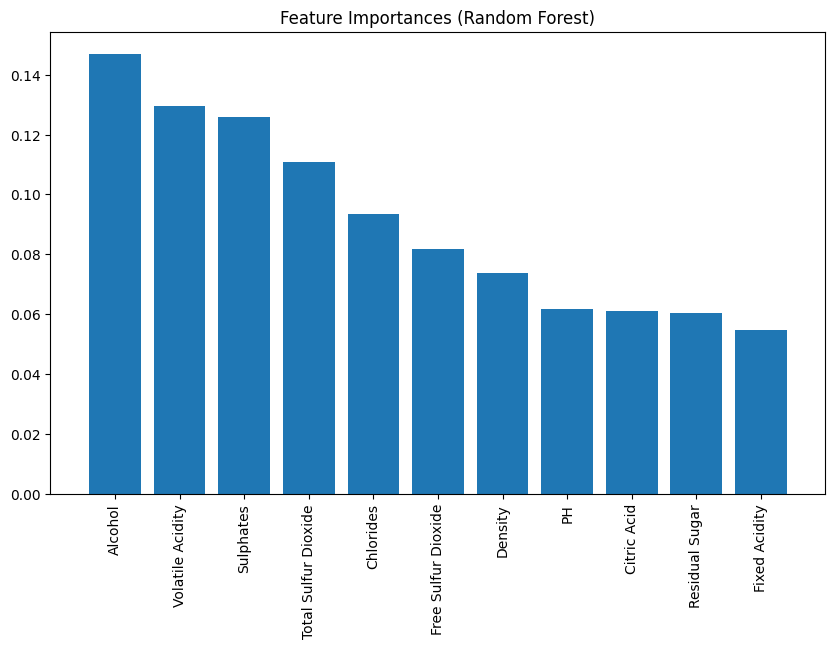

In [7]:
# ============================================================
# Final Evaluation and Feature Importance
# ============================================================
# Evaluate and display metrics for the best Random Forest model.
Y_Pred_Best_RF = Best_RF.predict(X_Test)
Best_RF_Accuracy, Best_RF_Report, Best_RF_CM = Evaluate_Model(Y_Test, Y_Pred_Best_RF)
print(f"Best Random Forest Model:\nAccuracy: {Best_RF_Accuracy:.2f}\n")
print(Best_RF_Report)
Plot_Confusion_Matrix(Best_RF_CM, "Best Random Forest")

# Evaluate and display metrics for the best SVC model.
Y_Pred_Best_SVC = Best_SVC.predict(X_Test)
Best_SVC_Accuracy, Best_SVC_Report, Best_SVC_CM = Evaluate_Model(Y_Test, Y_Pred_Best_SVC)
print(f"Best SVC Model:\nAccuracy: {Best_SVC_Accuracy:.2f}\n")
print(Best_SVC_Report)
Plot_Confusion_Matrix(Best_SVC_CM, "Best SVC")

# Feature importance.
Importances = Best_RF.named_steps['classifier'].feature_importances_
indices = NP.argsort(Importances)[::-1]
PLT.figure(figsize=(10, 6))
PLT.title("Feature Importances (Random Forest)")
PLT.bar(range(X_Train.shape[1]), Importances[indices], align="center")
PLT.xticks(range(X_Train.shape[1]), X_Train.columns[indices], rotation=90)
PLT.xlim([-1, X_Train.shape[1]])
PLT.show()

In [8]:
# ============================================================
# Save Models and Scalers for Deployment
# ============================================================
# Save the models and scalers.
JobLib.dump(Best_RF, 'Best_RF_Wine_Model.pkl')
JobLib.dump(Best_SVC, 'Best_SVC_Wine_Model.pkl')
JobLib.dump(Best_RF.named_steps['scaler'], 'Scaler_RF.pkl')
JobLib.dump(Best_SVC.named_steps['scaler'], 'Scaler_SVC.pkl')

['Scaler_SVC.pkl']